In [24]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import math

import warnings
warnings.filterwarnings('ignore') # Fix NumPy issues

### Let's generate two-dimensional dataset containing four distinct blobs

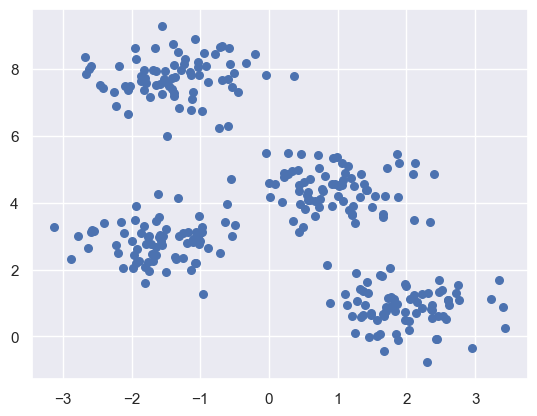

In [25]:
from sklearn.datasets import make_blobs

X, y_true = make_blobs(n_samples=300, centers=4,cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=30)
plt.show()

### Using Kmeans algorithm from the sklearn Library

In [26]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='magenta', s=100);

### Write your own algorithm

In [121]:
def dist(x1, x2):
    return np.sqrt(np.sum((x1-x2)**2))
    
def find_clusters(X, n_clusters, rseed=2):
    rng = np.random.RandomState(rseed)
    centers = np.zeros((n_clusters, 2))
    
    for i in range(n_clusters):
        centers[i][0] = rng.uniform(np.min(X[:, 0]), np.max(X[:, 0]))
        centers[i][1] = rng.uniform(np.min(X[:, 1]), np.max(X[:, 1]))
    labels = np.zeros(len(X))
    tol = 0
    
    while True:        
        #Assign labels based on closest center
        
        for i in range(len(X)):
            distance_arr = [dist(X[i], centers[n]) for n in range(len(centers))]
            labels[i] = np.argmin(distance_arr)
        #Find new centers from means of points

        averages = np.zeros((n_clusters, 2))
        for i in range(len(X)):
            averages[int(labels[i])] += X[i]
        for i in range(len(averages)):
            if np.count_nonzero(labels == i) != 0:
                averages[i] /= np.count_nonzero(labels == i)

        if tol == 10:
            break
        centers = averages
        tol += 1
    return centers, labels

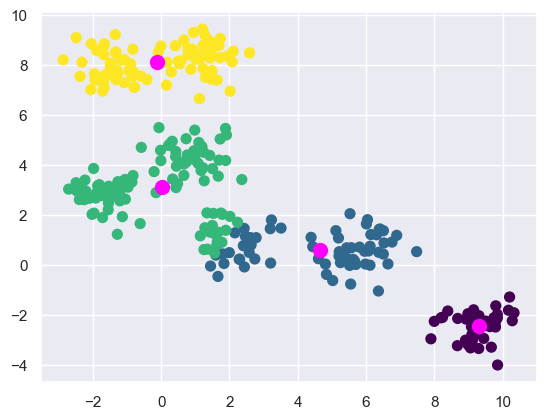

In [122]:
centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');
plt.scatter(centers[:, 0], centers[:, 1], c='magenta', s=100)

### Another test

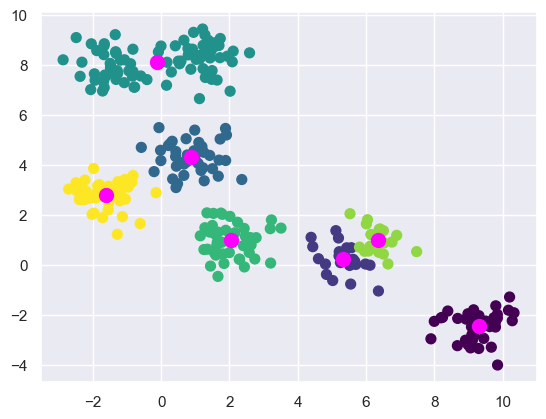

In [123]:
n_cen = 7
X, y_true1 = make_blobs(n_samples=300, centers=n_cen,cluster_std=0.61, random_state=0)
centers, labels = find_clusters(X, n_cen)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');
plt.scatter(centers[:, 0], centers[:, 1], c='magenta', s=100)

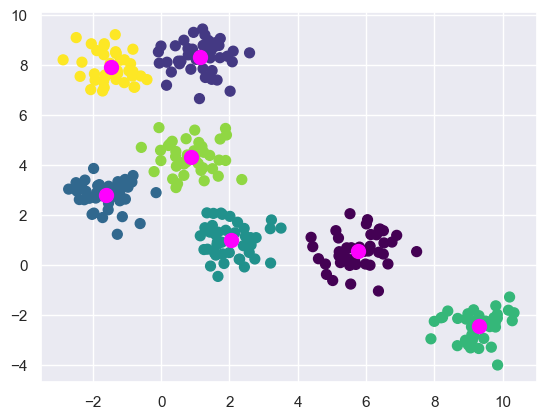

In [124]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=n_cen)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='magenta', s=100);

## Example: k-means for color compression

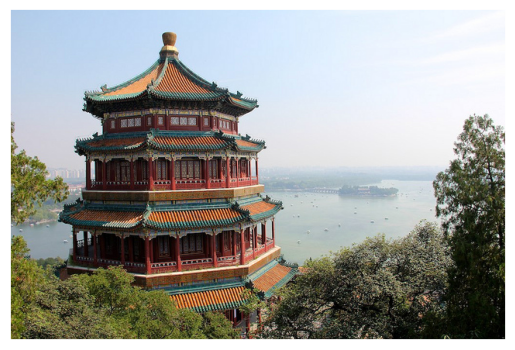

In [125]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

The image itself is stored in a three-dimensional array of size (height, width, RGB), containing red/blue/green contributions as integers from 0 to 255:

In [6]:
china.shape

(427, 640, 3)

One way we can view this set of pixels is as a cloud of points in a three-dimensional color space. We will reshape the data to [n_samples x n_features], and rescale the colors so that they lie between 0 and 1:

In [7]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

In [8]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

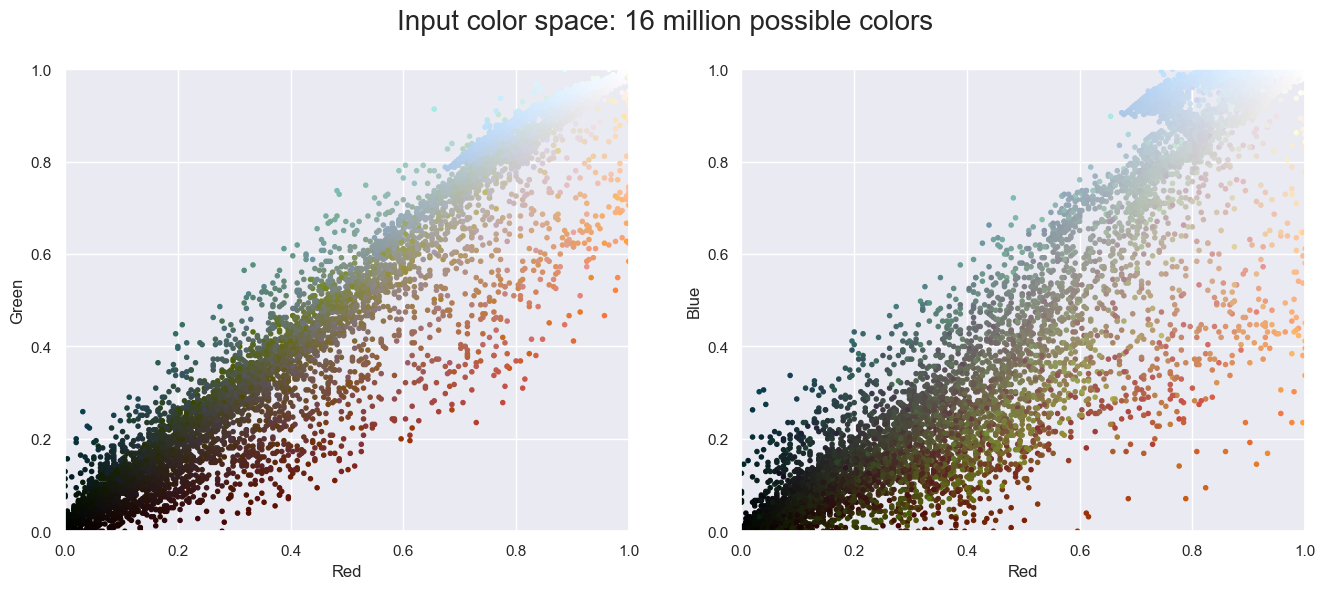

In [9]:
plot_pixels(data, title='Input color space: 16 million possible colors')

let's reduce these 16 million colors to just 16 colors, using a k-means clustering across the pixel space

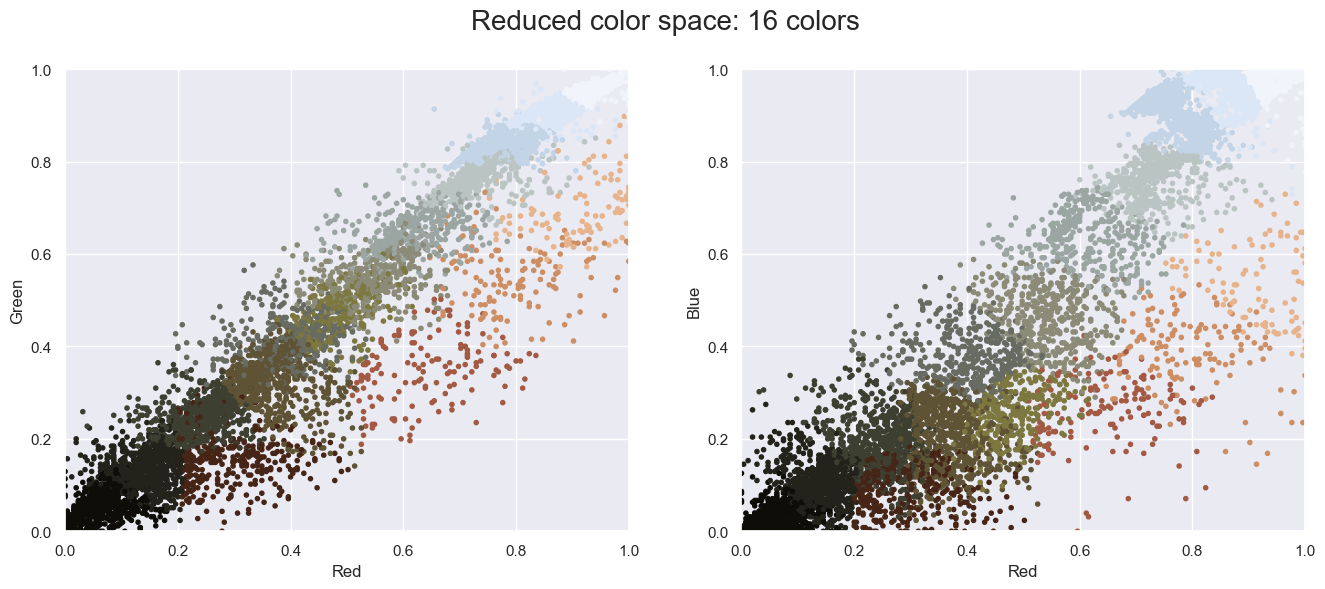

In [10]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

The result is a re-coloring of the original pixels, where each pixel is assigned the color of its closest cluster center. Plotting these new colors in the image space rather than the pixel space shows us the effect of this:

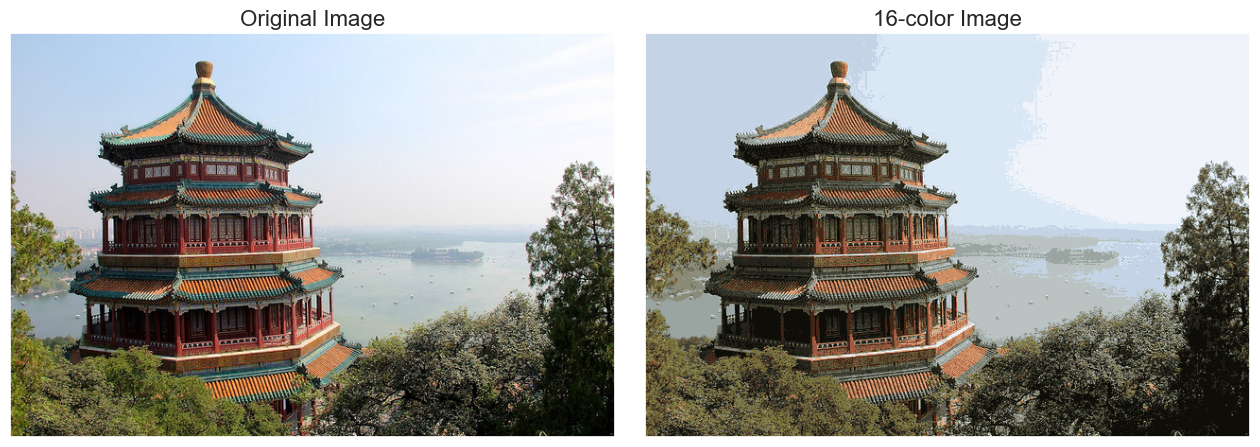

In [11]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

Some detail is certainly lost in the rightmost panel, but the overall image is still easily recognizable. This image on the right achieves a compression factor of around 1 million! While this is an interesting application of k-means, there are certainly better way to compress information in images. But the example shows the power of thinking outside of the box with unsupervised methods like k-means.